# ch5 粒子與優化

相信在前面的章節已經介紹了很多有關於節點的內容，甚至還引入了層模型的觀念。所謂層模型就是一種可以優化的單元，甚至網路本身也可以看作是層模型。

但其實網路和層模型都是屬於 **粒子(particle)** 底下的一種而已，那麼什麼是粒子呢？

## 粒子

在nyto中，所有可優化的東西都是粒子，也就是說網路本身是粒子，`nyto.layer`底下的模型也是粒子。在nyto中所有針對網路或是模型的優化行為，本質上是針對粒子的運算行為。若是該模型不是粒子或是該模型雖然是粒子但不能運算，則該模型不能被優化。

下面我們就來看看如何對粒子進行運算。

In [1]:
from nyto import layer
from nyto import net_tool as to
from nyto.net_tool import get
import numpy as np

### 粒子對數字的運算

粒子對數字的運算結果會是一個粒子，粒子對數字的運算可以簡單依循下面的規則:
1. 如果是網路對數字的運算，則網路內模型單元中的所有粒子對該數字做相同的運算
2. 如果是層模型對數字的運算，則網路內的參數對該數字做相同的運算

**層模型對數字的運算**

In [2]:
var = layer.new_variable_layer((2,2))
var

variable_layer([[0. 0.]
 [0. 0.]])

In [3]:
var + 1

variable_layer([[1. 1.]
 [1. 1.]])

**網路對數字的運算**

In [4]:
nn, node = to.new_net(
    particle_and_mod=layer.new_nn_layer((2,2)),
    particle_but_not_a_mod=to.add_data(layer.new_variable_layer((2,2))),
    mod_but_not_a_particle=0
)

In [5]:
new_nn = nn + 1
new_node = to.create_connecter(new_nn)

In [6]:
get(new_node.particle_and_mod)

nn_layer([[1. 1.]
 [1. 1.]],
[[1. 1.]])

In [7]:
get(new_node.particle_but_not_a_mod)

variable_layer([[0. 0.]
 [0. 0.]])

In [8]:
get(new_node.mod_but_not_a_particle)

0

### 粒子對粒子的運算

粒子對粒子的運算結果會是一個粒子，粒子對粒子的運算可以簡單依循下面的規則:
1. 如果是網路對網路的運算: 則雙方模型單元中相同名字的粒子做同樣的運算。
2. 如果是層模型對層模型的運算: 則雙方相對位置的參數做同樣的運算。
3. 不要進行網路對層模型的運算。

基本上，雖然理論上支持網路跟層模型的運算，但是實際上並不能成功。不同網路間的運算成立條件非常嚴格，通常兩個網路必須擁有相同的結構，基本上是來自同一個網路的通過計算產生的網路才能互相計算。

**層模型對層模型的運算**

In [9]:
var1=layer.np_to_variable_layer(np.arange(9).reshape(3,3))
var2=layer.np_to_variable_layer(np.arange(9,18).reshape(3,3))

var1, var2

(variable_layer([[0 1 2]
  [3 4 5]
  [6 7 8]]),
 variable_layer([[ 9 10 11]
  [12 13 14]
  [15 16 17]]))

In [10]:
var1+var2

variable_layer([[ 9 11 13]
 [15 17 19]
 [21 23 25]])

**網路對網路的運算**

In [11]:
import numpy as np

nn1, node1 = to.new_net(
    mod_but_not_a_particle=1,
    particle_but_not_a_mod=to.add_data(layer.np_to_variable_layer(np.arange(3))),
    particle_and_mod=layer.np_to_variable_layer(np.arange(4).reshape(2,2))
)

nn2, node2 = to.new_net(
    mod_but_not_a_particle=2,
    particle_but_not_a_mod=to.add_data(layer.np_to_variable_layer(np.arange(3,6))),
    particle_and_mod=layer.np_to_variable_layer(np.arange(4,8).reshape(2,2))
)

new_nn = nn1 + nn2
new_node = to.create_connecter(new_nn)

In [12]:
get(new_node.mod_but_not_a_particle)

1

In [13]:
get(new_node.particle_but_not_a_mod)

variable_layer([0 1 2])

In [14]:
get(new_node.particle_and_mod)

variable_layer([[ 4  6]
 [ 8 10]])

可以發現當網路內有非粒子的模型時，粒子繼承來自運算符號左邊的粒子的模型。

### 粒子運算的繼承關係

當粒子發生運算時，會產生一個新的粒子，新的粒子會繼承原先粒子中的一些資訊。但繼承的方式會有所不同，具體如下:
1. 對於資料單元: 與原先粒子共用同一個資料單元
2. 對於模型單元: 複製一份模型單元
3. 節點資訊: 與原先粒子共用

所以對於函數模型或是訓練用的資料，這些不會被修改的單元，我們要放在資料單元與延生粒子共用。而對於模型參數這些粒子自己獨有的部份，我們要放在模型單元。這不僅僅只是為了節省空間，還可以提升速度。

這不僅僅適用於粒子運算，網路優化也是一樣。因為網路優化也是使用粒子運算實現的。

## 隨機粒子

當我們需要讓粒子的參數增加一些隨機性的時候，我們可以讓粒子與一個具有隨機性的粒子進行粒子運算。下面提供了常見的產生隨機性的粒子的函數，函數通常需要提供一個原粒子，然後函數會回傳一個結構與原粒子相同但參數不同的粒子。

下面是常用的隨機函數:

**random_particle**

    新粒子的參數會被隨機在0到1之間。
    
**normal_particle**

    新粒子的參數會被隨機在一個標準常態分配。
    
**unit_particle**

    新粒子的參數會被隨機，但全部參數會被限制在一個長度為1的狀態。
    可以視新粒子為一參數空間中的單位向量。

產生隨機性的粒子比較常見的其中一個用途就是用來繪製目標函數的長相，我們可以通過討整目標函數的設計，使得目標函數看起來更平滑或是更易於訓練。

我們一樣以鳶尾花資料集為例，繪製不同目標函數的長相:

In [15]:
from sklearn import datasets

iris = datasets.load_iris()     # 載入資料
feature = iris.data             # 輸入的特徵資料
label = np.eye(3)[iris.target]  # 預測的類別資料

In [16]:
feature.shape, label.shape      # 查看數據的結構

((150, 4), (150, 3))

In [17]:
from nyto import unit_function as uf

nn, node = to.new_net(
    data_x = to.add_data(feature),
    data_y = to.add_data(label),
    layer1 = layer.new_nn_layer((4,6)),
    layer2 = layer.new_nn_layer((6,3)),
)

node.layer1_output = node.data_x >> uf.col_nor() >> node.layer1 >> uf.tanh()
node.layer2_output = node.layer1_output >> node.layer2 >> uf.softmax()
node.pre = node.layer2_output

node.cross_entropy = uf.cross_entropy(node.pre, node.data_y)
node.MSE = uf.MSE(node.pre, node.data_y)
node.MAE = uf.MAE(node.pre, node.data_y)

node.loss = nn.launcher(node.cross_entropy, node.MSE, node.MAE)

使用`train_tool.unit_particle`來產生一個單位向量，並用該單位向量計算沿著該方向的各種loss值:

In [18]:
from nyto import train_tool as train

unit_nn = train.unit_particle(nn) # 產生一個單位向量
step_list = list(range(-10,11)) # 保存步長

cross_entropy_list=[]
MSE_list=[]
MAE_list=[]
for step in step_list:
    new_nn = nn + step*unit_nn
    new_node = to.create_connecter(new_nn)
    
    loss = get(new_node.loss)
    cross_entropy_list.append(loss['cross_entropy'])
    MSE_list.append(loss['MSE'])
    MAE_list.append(loss['MAE'])

繪製目標函數的長相:

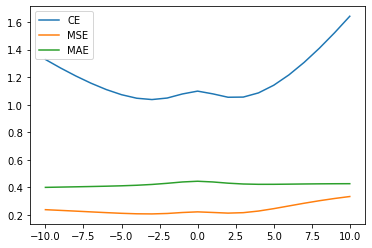

In [19]:
import matplotlib.pyplot as plt

plt.plot(step_list,cross_entropy_list, label="CE")
plt.plot(step_list,MSE_list, label="MSE")
plt.plot(step_list,MAE_list, label="MAE")

plt.legend()

## 優化

誠然使用者可以通過粒子運算自己打造自己的優化方式，但是如果有現成的工具可以使用何樂而不為呢？下面就來介紹nyto內建的優化網路工具。

### dropout

在深度學習中dropout算是十分重要的功能。要在nyto中使用dropout，有幾點要說明:
1. nyto中的dropout的實現方式是通過dropconnect實現的。
2. 必須在導入模型階段指定該模型是否需要啟用dropout。
3. 啟用dropout後還需要在訓練時指定使用dropout訓練。
4. 訓練完成後可以使用`trian_tool.inverse_dropout`調整參數。

下面示範在導入模型時怎麼啟用dropout:

In [20]:
nn, node = to.new_net(
    var=layer.new_variable_layer((2,2), dropout=True),
    nn=layer.new_nn_layer((2,2), dropout=True),
    lstm=layer.new_random_lstm((2,2), dropout=True),
    conv=layer.new_conv_layer((2,2,2), dropout=True)
)

啟用了dropout並不代表模型在訓練時是使用dropout的方式訓練的，還必須在訓練時使用dropout的功能。反之就算使用了dropout的方式訓練，但是模型並沒有啟用dropout，雖然也可以訓練，但是並不會有模型是使用dropout的方式訓練的。

### 池

池可以簡單想成是有許多網路的一個集合，基於群體智彗的演算法往往需要使用大量的個體，這既是優點也是缺點。優點是由於搜索的範圍大，比較不容易陷入到不好的局部最佳中;缺點就是運算量大，收斂速度沒有基於梯度下降的方式快。

nyto基於改良於粒子群演算法的演算法，可以在兩者中取得平衡。池中個體的數量將不再是那麼重要，使用者可以依據需要設定池的大小，即便池中只有一個個體，此時演算法依然可以正常運作，此時演算法的運作方式接近於梯度下降。如果遇到困難，可以將池變大，此時演算法接近於粒子群演算法。當然實際使用上不需要如此極端，池的大小只需要按個人需要使用即可。

而要生成一個池可以使用*new_pool*函數產生，下面是介紹:

`new_pool`

**node_if**

    需要優化的節點，優化的最終目標是讓該節點的輸出值最小。
    資料型別是node_interface(節點界面)。
    
**pool_size**

    池大小,資料型別是int。
    
**random_size**

    亂數生成個體時常態分配的標準差，平均數為給定化節點的網路個體。
    預設為1。
    
**keep**

    是否在池中保留原始網路，資料型別是bool。
    預設為False。
 
對於池，我們可以通過排名的順序查看不同個體，排名方式基於給定的優化節點。下面我們來生成一個池:

In [21]:
# 生成網路
nn, n = to.new_net(
    var=layer.new_variable_layer((2,2)),
    np_sum=to.add_data(np.sum),
    np_mean=to.add_data(np.mean)
)

# 建立需要優化的節點(可以有多個)
n.sum = uf.to_np(n.var) >> n.np_sum
n.mean = uf.to_np(n.var) >> n.np_mean

In [22]:
# 生成池
pool = train.new_pool(n.sum, pool_size=10)

查看池的大小:

In [23]:
len(pool)

10

取得優化值最小的網路:

In [24]:
pool.net[0]

net(mod={'var'}, data={'np_mean', 'np_sum'})

取得優化值前5名的網路:

In [25]:
pool.net[:5]

[net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'})]

取得前5名的優化值:

In [26]:
pool.loss[:5]

[-3.964276007428662,
 -2.9747466295541156,
 -0.9687910678567999,
 -0.8460589438691893,
 -0.009750870117858648]

將前5名的網路分割成一個新的池:

In [27]:
new_pool = pool[:5]

修改池中優化值所對應的節點名稱:

In [28]:
pool_with_node_mean = pool.reset_node_id(node_id='mean')

pool.loss[0], pool_with_node_mean.loss[0]

(-3.964276007428662, -0.9910690018571655)

在池中每網路都有一個編號，編號從0開始依序分配給每個網路。如果想要取得按編號排序的網路組，可以使用`net.real`屬性，該屬性會回傳一個按實際編號排序的網路參考的list:

In [29]:
pool.net.real

[net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'}),
 net(mod={'var'}, data={'np_mean', 'np_sum'})]

如果想取得按實際編號排序的優化值可以使用`loss.real`屬性，該屬性會回傳一個按實際編號排序的優化值的list:

In [30]:
pool.loss.real

[-2.9747466295541156,
 -0.009750870117858648,
 -0.9687910678567999,
 -3.964276007428662,
 -0.8460589438691893,
 1.263853563622276,
 3.525571134145588,
 2.262497943475256,
 0.6046562163874766,
 0.5647735153278779]

**替換網路**

可以使用`net`或是`real_net`對池中的網路進行網路的替換，前者是按優化值排序定位網路，後者是按實際編號定位網路:

In [31]:
pool.net[0] = -pool.net[0]
pool.real_net[0] = -pool.real_net[0]

In [32]:
pool.loss.real

[2.9747466295541156,
 -0.009750870117858648,
 -0.9687910678567999,
 3.964276007428662,
 -0.8460589438691893,
 1.263853563622276,
 3.525571134145588,
 2.262497943475256,
 0.6046562163874766,
 0.5647735153278779]

### 優化池

當池被生成出來後就可以使用優化函數優化整個池，優化結束時池中的不同個體的結果都是不同的，使用者可以使用池中最優秀的個體當成結果，也可以取前幾名當成結果，甚至可以在預測時讓池中的個體們投票的方式決定預測結果。

與網路一樣，池本身也是一種粒子，所以也可以進行粒子運算:

In [33]:
new_pool = pool + 1

雖然可以對池做粒子運算很令人興奮，但是如果要優化池中的網路，建議使用池優化器來進行優化。目前內建的池優化器有`epso_opt`，該演算法是基於粒子群算法改良的算法。下面是對相關參數的介紹:

`trian_tool.epso_opt`

**threshold**

    擇優的門檻，越小越嚴格，為一大於0的值。預設1。

**dropout_rate**

    dropout的機率，為None時則為不dropout。
    預設None。
    
**step_rate**

    單次訓練優化的程度，介於0到1之間。預設是1。
    使用批訓練時，可以調小該值，降低訓練速度防止過度擬合部份資料。
    
**bound**
    
    優化上下界限，防止訓練時參數突然變化過大，當為None時為不設限。
    預設100。


當優化器進行優化時，如果遇到需要使用批訓練的狀況時，可以使用`train_batch`函數來省去切換啟動器節點的部份代碼，下面是各參數的說明:

`trian_tool.train_batch`

**batch_node_list**

    裝有啟動器節點的list，該函數會自動切換list中的節點，來替換池中的優化節點名稱。
    當全部啟動器節點被替換過一次稱之為一個epoch，切換一個啟動器節點稱之為一個step。
    當epoch結束時，step重新計算。
    
**pool**

    要優化的池。
    
**opt**

    使用的優化器。
    
**step**

    每訓練幾個step回傳一次結果。預設是1。
    
**epoch**

    總共訓練幾個epoch，預設為1。
    
函數回傳的結果為一迭代器，迭代器回傳3個值，分別為:
1. (ep, idx): 為第幾個epoch和第幾個step
2. new_pool: 優化後的池
3. opt: 當前使用的優化器，可以隨時更新優化器

當迭代器結束時，會回傳最後一次然後結束。使用起來大概像下面這樣:

    for t,new_pool,opt in train_batch(batch_node_list, pool, opt):
    
        (ep, idx)=t
        
        # do something...
        

### dropout還原

當使用dropout訓練結束時，我們需要將模型的權重根據dropout rate來調整成可以直接使用的狀態。在nyto中使用`inverse_dropout`來調整:

`trian_tool.inverse_dropout`

**nn**

    需要調整的網路
    
**dropout_rate**

    訓練時使用的dropout rate。
    
函數回傳結果是一個調整後的網路。

## 固定模型

有時候訓練的時候我們想要固定住某些模型的參數，而只訓練其他模型的參數該時，可以使用`net_tool.fix_mod`來固定，這時該粒子將無法被進行任何的粒子運算，自然也就不會參與到優化中了。而當想解除固定時，則可以使用`net_tool.unfix_mod`來解除固定。

In [34]:
nn, node = to.new_net(
    fixed_mod=layer.np_to_variable_layer(np.arange(5)),
    unfixed_mod=layer.np_to_variable_layer(np.arange(5))
)

# 對網路中的模型fixed_mod進行固定
to.fix_mod(nn, 'fixed_mod')

# 查看固定前的狀態
to.get(node.fixed_mod, node.unfixed_mod)

(variable_layer([0 1 2 3 4]), variable_layer([0 1 2 3 4]))

比較固定與沒固定的模型在進行粒子運算的前後差異，可以發現只有沒被固定的模型進行了運算:

In [35]:
new_nn = nn + 10
new_nn_node = to.create_connecter(new_nn)

to.get(new_nn_node.fixed_mod, new_nn_node.unfixed_mod)

(variable_layer([0 1 2 3 4]), variable_layer([10 11 12 13 14]))

可以使用`net.info.mod_is_fix`確認網路中的模型是否被固定:

In [36]:
nn.info.mod_is_fix('fixed_mod')

True

In [37]:
nn.info.mod_is_fix('unfixed_mod')

False

使用`net_tool.unfix_mod`解除固定:

In [38]:
to.unfix_mod(nn, 'fixed_mod')

確認模型是否已經被解除固定:

In [39]:
nn.info.mod_is_fix('fixed_mod')

False

## 結語

到此nyto的使用方法已經介紹完畢，希望大家能用的開心。

***

*END*